# Domain Adaptation with Maximum Mean Discrepancy (MMD)

In [14]:
from PIL import Image
from cityscapesscripts.helpers import labels
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import gc
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import Cityscapes
from backbones_unet.model.unet import Unet

In [15]:
# Set seeds for reproducibility
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
SEED = 42
set_seeds(SEED)
print(f"Seeds set for reproducibility is {SEED}")

Seeds set for reproducibility is 42


In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.mps.is_available() 
                      else "cpu"
                    )
print(DEVICE)

mps


In [17]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, targets_dir, image_transform=None, target_transform=None):
        """
        Args:
            images_dir (string): Directory with all the images.
            targets_dir (string): Directory with all the target masks.
            image_transform (callable, optional): Optional transform to be applied on images.
            target_transform (callable, optional): Optional transform to be applied on targets.
        """
        self.images_dir = images_dir
        self.targets_dir = targets_dir
        self.image_transform = image_transform
        self.target_transform = target_transform
        
        # Get all image filenames
        self.image_filenames = [f for f in os.listdir(images_dir) 
                               if f.lower().endswith(('.png'))]
        self.image_filenames.sort()
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load target mask
        target_name = img_name.replace('.png', '_trainId.png')
        target_path = os.path.join(self.targets_dir, target_name)
        target = Image.open(target_path)
        
        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.target_transform:
            target = self.target_transform(target)
       # else:
       #     # Default: convert to tensor
       #     target = torch.from_numpy(target)
        
        return image, target

### Loading the Synthetic Dataset

In [18]:
path_images = "../syn_resized_images"
path_target = "../syn_resized_gt"

image_transform = transforms.Compose([
    transforms.Resize((256, 480)), # We maintain the og aspect ratio
    transforms.ToTensor(),  # Converts PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet parameters
])

target_transform = transforms.Compose([
    transforms.Resize((256, 480), interpolation=Image.NEAREST), # This interpolation ensure that all pixels have a correct value of their class
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())
])
syn_dataset = SegmentationDataset(images_dir=path_images, targets_dir=path_target, image_transform=image_transform, target_transform=target_transform)

### Splitting Synthetic Dataset

In [19]:
# Get total dataset size
total_size = len(syn_dataset)
print(f"Total dataset size: {total_size}")

# Calculate split sizes (60% train, 10% val, 30% test)
train_size = int(0.6 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Train size: {train_size} ({train_size/total_size*100:.1f}%)")
print(f"Validation size: {val_size} ({val_size/total_size*100:.1f}%)")
print(f"Test size: {test_size} ({test_size/total_size*100:.1f}%)")

# Create random splits
syn_train_dataset, syn_val_dataset, syn_test_dataset = random_split(
    syn_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)  # For reproducibility
)

# Create DataLoaders
batch_size = 4 #8

syn_train_dataloader = DataLoader(
    syn_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED) 
)

syn_val_dataloader = DataLoader(
    syn_val_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

syn_test_dataloader = DataLoader(
    syn_test_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(syn_train_dataloader)}")
print(f"Validation batches: {len(syn_val_dataloader)}")
print(f"Test batches: {len(syn_test_dataloader)}")

Total dataset size: 12500
Train size: 7500 (60.0%)
Validation size: 1250 (10.0%)
Test size: 3750 (30.0%)

DataLoaders created:
Train batches: 1875
Validation batches: 313
Test batches: 938


### Loading the Real Dataset

In [20]:
def cityscapes_mask_to_train_ids(mask):
    mask_np = np.array(mask)
    labels_mapping = {label.id: label.trainId for label in labels.labels if label.trainId != -1}
    labels_mapping[-1] = 255  # Map invalid labels to 255
    mask_np = np.vectorize(labels_mapping.get)(mask_np)
    mask_np = np.where(mask_np <= 18, mask_np, 255).astype(np.uint8)  # Ensure that all pixels are within the range of train IDs
    return torch.from_numpy(mask_np).long()

real_target_transform = transforms.Compose([
    transforms.Resize((256, 480), interpolation=Image.NEAREST), # This interpolation ensure that all pixels have a correct value of their class
    transforms.Lambda(lambda x: cityscapes_mask_to_train_ids(x))  # Convert Cityscapes mask to train IDs
])

real_train_dataset = Cityscapes(
    root='../cityscapes',
    split='train',
    mode='fine',
    target_type='semantic',
    transform=image_transform,
    target_transform=real_target_transform
)

real_val_dataset = Cityscapes(
    root='../cityscapes',
    split='val',
    mode='fine',
    target_type='semantic',
    transform=image_transform,
    target_transform=real_target_transform
)

real_test_dataset = Cityscapes(
    root='../cityscapes',
    split='test',
    mode='fine',
    target_type='semantic',
    transform=image_transform,
    target_transform=real_target_transform
)

# Print dataloaders sizes
real_total_size = len(real_train_dataset) + len(real_val_dataset) + len(real_test_dataset)
print(f"Total dataset size: {real_total_size}")
print(f"Train size: {len(real_train_dataset)} ({len(real_train_dataset)/real_total_size*100:.1f}%)")
print(f"Validation size: {len(real_val_dataset)} ({len(real_val_dataset)/real_total_size*100:.1f}%)")
print(f"Test size: {len(real_test_dataset)} ({len(real_test_dataset)/real_total_size*100:.1f}%)")

Total dataset size: 5000
Train size: 2975 (59.5%)
Validation size: 500 (10.0%)
Test size: 1525 (30.5%)


In [21]:
real_train_dataloader = DataLoader(
    real_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

real_val_dataloader = DataLoader(
    real_val_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

real_test_dataloader = DataLoader(
    real_test_dataset,
    batch_size=batch_size,
    shuffle=True,  
    #num_workers=2,
    generator=torch.Generator().manual_seed(SEED)
)

In [22]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=0.1, ignore_index=None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        """
        inputs: (N, C, H, W) - logits (non softmaxati)
        targets: (N, H, W)   - ground truth con classi (0...C-1)
        """
        num_classes = inputs.shape[1]
        device = inputs.device  # Get device from input tensor
        
        # Softmax sulle predizioni
        probs = F.softmax(inputs, dim=1)  # (N, C, H, W)
        
        # Handle ignore_index by creating a mask and filtering out ignored pixels
        if self.ignore_index is not None:
            # Create mask for valid pixels
            valid_mask = (targets != self.ignore_index)  # (N, H, W)
            
            # Only process valid pixels
            valid_targets = targets[valid_mask]  # (N_valid,)
            
            # Reshape probs to match and filter valid pixels
            probs_reshaped = probs.permute(0, 2, 3, 1)  # (N, H, W, C)
            valid_probs = probs_reshaped[valid_mask]  # (N_valid, C)
            
        else:
            # No ignore_index, process all pixels
            valid_targets = targets.view(-1)  # (N*H*W,)
            valid_probs = probs.permute(0, 2, 3, 1).contiguous().view(-1, num_classes)  # (N*H*W, C)
        
        # One-hot encoding of valid targets only
        if len(valid_targets) > 0:
            targets_one_hot = F.one_hot(valid_targets, num_classes=num_classes).float()  # (N_valid, C)
        else:
            # If no valid pixels, create a zero loss that maintains gradients
            # Use a small operation on the input to maintain gradient flow
            zero_loss = (inputs * 0.0).sum()  # This maintains gradients from inputs
            return zero_loss
        
        # Calcolo Dice per ogni classe usando solo pixel validi
        intersection = (valid_probs * targets_one_hot).sum(dim=0)  # (C,)
        union = valid_probs.sum(dim=0) + targets_one_hot.sum(dim=0)  # (C,)
        
        
        smooth_tensor = torch.tensor(self.smooth, device=device, dtype=intersection.dtype)
        dice = (2.0 * intersection + smooth_tensor) / (union + smooth_tensor)
        
        # Media sulle classi
        loss = 1.0 - dice.mean()
        return loss

## Maximum Mean Discrepancy Loss (MMD) 
$$
    MMD(X, Y) = \frac{1}{|X|^2} \sum_{i,j} k(x_i, x_j) - \frac{2}{|X||Y|} \sum_{i,j} k(x_i, y_j) + \frac{1}{|Y|^2} \sum_{i,j} k(y_i, y_j)
$$
where:
- $k$ is a kernel function (e.g., Gaussian).
- $X$ is the source domain (MNIST) and $Y$ is the target domain (SVHN).
- $x_i$ and $y_j$ are samples from the respective domains.
- $|X|$ and $|Y|$ are the number of samples in each domain.

In [23]:
# Define MMD loss between source and target feature batches
def rbf_kernel(a, b, sigma):
    a = a.unsqueeze(1) 
    b = b.unsqueeze(0) 
    dist = (a - b).pow(2).sum(2) 
    return torch.exp(-dist / (2 * sigma ** 2))

def MMD_loss(x, y, sigma=1.0):

    K_xx = rbf_kernel(x, x, sigma)
    K_yy = rbf_kernel(y, y, sigma)
    K_xy = rbf_kernel(x, y, sigma)
    mmd = K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()
    return mmd

In [24]:
import ssl
import urllib.request
from contextlib import contextmanager
# Disable SSL verification for urllib requests on MacOS
# This is a workaround for the "SSL: CERTIFICATE_VERIFY_FAILED" error on MacOS
@contextmanager
def no_ssl_verification():
    """Temporarily disable SSL verification"""
    old_context = ssl._create_default_https_context
    ssl._create_default_https_context = ssl._create_unverified_context
    try:
        yield
    finally:
        ssl._create_default_https_context = old_context

NUM_CLASSES = 19
LR = 1e-4

CE_loss = nn.CrossEntropyLoss(ignore_index=255)  # 255 = unlabeled
Dice_loss = DiceLoss(smooth=0.1, ignore_index=255)  

ce_importance = 0.7
mmd_weight = 0.1

def criterion(outputs, targets):
    ce_loss = CE_loss(outputs, targets)
    dice_loss = Dice_loss(outputs, targets)

    cls_loss = ce_importance * ce_loss + (1 - ce_importance) * dice_loss
    return cls_loss


In [25]:
# Load model

# Instantiate the model architecture
if DEVICE.type == 'mps': 
    print("mps detected, using no_ssl_verification")
    with no_ssl_verification():
        model = Unet(
            backbone='resnet50',
            pretrained=True,
            in_channels=3,
            num_classes=NUM_CLASSES,
        )
else:
    model = Unet(
        backbone='resnet50',
        pretrained=True,
        in_channels=3,
        num_classes=NUM_CLASSES,
    )
    
model = model.to(DEVICE)

# Load the checkpoint and filter out aux_classifier keys
best_model_path = "../models/unet_imagenet1k_480x256_best_model.pth"
checkpoint = torch.load(best_model_path, map_location=DEVICE)
print (f"Loading model from: {best_model_path}")

name = "DA_unet_imagenet1k_480x256"

state_dict = checkpoint["model_state_dict"]
model.load_state_dict(state_dict, strict=False)
optimizer = optim.Adam(model.parameters(), lr=LR)

mps detected, using no_ssl_verification
Loading model from: ../models/unet_imagenet1k_480x256_best_model.pth


In [26]:
def compute_iou(preds, labels, num_classes, ignore_index=255):
    
    preds = torch.argmax(preds, dim=1).detach().cpu()  # [B, H, W]
    
    labels = labels.detach().cpu() 
    
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        
        # Escludi pixel ignorati
        mask = (labels != ignore_index)
        pred_inds = pred_inds & mask
        target_inds = target_inds & mask

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            continue  # salta classe non presente
        ious.append(intersection / union)
    
    if len(ious) == 0:
        return float('nan')  # o 0.0 se preferisci
    return sum(ious) / len(ious)

In [27]:
def clear_memory():
    """Clear memory and cache for all device types"""
    # Run garbage collector
    gc.collect()
    
    # Get device from global scope
    if 'DEVICE' in globals():
        if DEVICE.type == 'cuda':
            torch.cuda.empty_cache()

        if DEVICE.type == 'mps':
            torch.mps.empty_cache()

    # Second GC run to make sure everything is cleaned up
    gc.collect()

In [28]:
def train_and_validate_epoch(
            model, optimizer, criterion, 
            syn_train_dataloader, syn_val_dataloader,
            real_train_dataloader, real_val_dataloader
    ):

    # Training phase
    model.train()
    train_total_loss = 0
    train_cls_loss = 0
    train_mmd_loss = 0
    train_iou_source = 0
    train_iou_target = 0

    syn_train_iter = iter(syn_train_dataloader)
    real_train_iter = iter(real_train_dataloader)
    
    steps = min(len(syn_train_iter), len(real_train_iter))

    for i in tqdm(range(steps),desc="Training"):
        source_data, source_labels = next(syn_train_iter)
        target_data, target_labels = next(real_train_iter)

        source_data, source_labels = source_data.to(DEVICE), source_labels.to(DEVICE)
        target_data = target_data.to(DEVICE)

        optimizer.zero_grad()  

        source_encoder_out = model.encoder(source_data)
        source_embeddings = source_encoder_out[-1]

        target_encoder_out = model.encoder(target_data)
        target_embeddings = target_encoder_out[-1]            

        source_output = model(source_data)#['out']
        target_output = model(target_data)#['out']

        cls_loss = criterion(source_output, source_labels)
        mmd_loss = MMD_loss(source_embeddings, target_embeddings)

        loss = cls_loss + mmd_weight * mmd_loss
        #loss = (1 - mmd_weight) * cls_loss + mmd_weight * mmd_loss
        
        loss.backward()
        optimizer.step()

        # Collect metrics (detach to prevent graph retention)
        train_total_loss += loss.detach().cpu().item()

        train_cls_loss += cls_loss.detach().cpu().item()
        train_mmd_loss += mmd_loss.detach().cpu().item()

        iou_target = compute_iou(target_output.detach().cpu(), target_labels, NUM_CLASSES)
        iou_source = compute_iou(source_output.detach().cpu(), source_labels, NUM_CLASSES)
        
        train_iou_source += iou_source
        train_iou_target += iou_target
        
        # Explicit cleanup of tensors to prevent memory leaks
        del source_data, source_labels, target_data, target_labels
        del source_embeddings, target_embeddings, source_output, target_output
        del loss, cls_loss, mmd_loss
        
        # Periodically clear memory (every 5 batches)
        if (i + 1) % 5 == 0:
            clear_memory()  
    
    clear_memory()
    
    source_train_avg_loss = train_total_loss / steps
    source_train_avg_iou = train_iou_source / steps
    target_train_avg_iou = train_iou_target / steps
    
    train_avg_mmd_loss = train_mmd_loss / steps
    
    # Validation 
    model.eval()
    val_total_loss = 0
    val_iou_source = 0
    val_iou_target = 0

    val_steps = min(len(syn_val_dataloader), len(real_val_dataloader))
    
    with torch.no_grad():

        syn_val_iter = iter(syn_val_dataloader)
        real_val_iter = iter(real_val_dataloader)

        for i in tqdm(range(val_steps), desc="Validation"):
            source_data, source_labels = next(syn_val_iter)
            target_data, target_labels = next(real_val_iter)
            source_data, source_labels = source_data.to(DEVICE), source_labels.to(DEVICE)
            target_data, target_labels = target_data.to(DEVICE), target_labels.to(DEVICE)

            outputs_source = model(source_data)#['out']
            outputs_target = model(target_data)#['out']

            loss_real = criterion(outputs_source, source_labels)
            loss_target = criterion(outputs_target, target_labels)

            val_total_loss += loss_real.detach().cpu().item() 
            val_iou_source += compute_iou(outputs_source.detach().cpu(), source_labels, NUM_CLASSES)
            val_iou_target += compute_iou(outputs_target.detach().cpu(), target_labels, NUM_CLASSES)

            # Explicit cleanup
            del source_data, source_labels, target_data, target_labels
            del outputs_source, outputs_target, loss_real, loss_target
            
            # Periodic memory clear
            if (i + 1) % 5 == 0:
                clear_memory()
    
    clear_memory()
    
    # Average losses and IOUs
    source_val_avg_loss = val_total_loss / val_steps
    source_val_avg_iou = val_iou_source / val_steps
    target_val_avg_iou = val_iou_target / val_steps
    
    print(f"The average mmd loss is {train_avg_mmd_loss:.4f}")
    return source_train_avg_loss, source_train_avg_iou, target_train_avg_iou, \
            source_val_avg_loss, source_val_avg_iou, target_val_avg_iou

In [29]:
def domain_adaptation(
        start_epoch, end_epoch,
        model, name,
        optimizer, criterion, 
        syn_train_dataloader, syn_val_dataloader, 
        real_train_dataloader, real_val_dataloader
    ):

    # Create models directory if it doesn't exist
    import os
    os.makedirs("models", exist_ok=True)

    # Store metrics for plotting
    st_losses = []  # Source Training losses
    st_ious = []  # Source Training IoUs
    tt_losses = []  # Target Training losses
    sv_losses = []  # Source Validation losses
    sv_ious = []  # Source Validation IoUs
    tv_ious = []  # Target Validation IoUs

    # Track best validation IoU for saving best model
    best_source_val_iou = 0.0
    best_target_val_iou = 0.0
    
    # Check if we need to resume from a checkpoint
    resume_epoch = start_epoch
    
    if start_epoch > 0:
        # Load checkpoint from the specified start_epoch
        checkpoint_path = f"models/{name}_epoch_{start_epoch}.pth"
        if os.path.exists(checkpoint_path):
            print(f"Loading checkpoint from: {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
            
            # Load model and optimizer state
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            
            # Load metrics history
            st_losses = checkpoint.get("st_losses", [])
            st_ious = checkpoint.get("st_ious", [])
            tt_losses = checkpoint.get("tt_losses", [])
            sv_losses = checkpoint.get("sv_losses", [])
            sv_ious = checkpoint.get("sv_ious", [])
            tv_ious = checkpoint.get("tv_ious", [])
            
            print(f"Resumed from epoch {start_epoch}")
            print(f"Last metrics - Source Val IoU: {sv_ious[-1] if sv_ious else 'N/A':.4f}, Target Val IoU: {tv_ious[-1] if tv_ious else 'N/A':.4f}")
            
            del checkpoint
        else:
            print(f"Warning: Checkpoint {checkpoint_path} not found. Starting training from scratch.")
    else:
        print(f"Starting training from scratch (start_epoch = 0).")
    
    # Load best validation IoUs from best model checkpoints
    best_source_checkpoint_path = f"models/{name}_best_unsupervised_model.pth"
    best_target_checkpoint_path = f"models/{name}_best_supervised_model.pth"
    
    if os.path.exists(best_source_checkpoint_path):
        best_source_checkpoint = torch.load(best_source_checkpoint_path, map_location=DEVICE)
        best_source_val_iou = best_source_checkpoint.get("source_val_avg_iou", 0.0)
        print(f"Loaded best source validation IoU: {best_source_val_iou:.4f}")
        del best_source_checkpoint
    
    if os.path.exists(best_target_checkpoint_path):
        best_target_checkpoint = torch.load(best_target_checkpoint_path, map_location=DEVICE)
        best_target_val_iou = best_target_checkpoint.get("target_val_avg_iou", 0.0)
        print(f"Loaded best target validation IoU: {best_target_val_iou:.4f}")
        del best_target_checkpoint
    
    start = time.time()
    set_seeds(SEED+resume_epoch)
    
    for epoch in range(resume_epoch, end_epoch):
        print(f"Epoch {epoch+1}/{end_epoch}")
        
        # Train and validate in one go
        source_train_avg_loss, source_train_avg_iou, target_train_avg_iou, \
            source_val_avg_loss, source_val_avg_iou, target_val_avg_iou = \
        train_and_validate_epoch(
            model, optimizer, criterion, 
            syn_train_dataloader, syn_val_dataloader,
            real_train_dataloader, real_val_dataloader
        )
        
        # Store metrics
        st_losses.append(source_train_avg_loss)
        st_ious.append(source_train_avg_iou)
        tt_losses.append(target_train_avg_iou)
        sv_losses.append(source_val_avg_loss)
        sv_ious.append(source_val_avg_iou)
        tv_ious.append(target_val_avg_iou)
        
        # Print results
        print(f"Source Train Loss: {source_train_avg_loss:.4f} | Source Train IoU: {source_train_avg_iou:.4f}")
        print(f"Target Train IoU: {target_train_avg_iou:.4f}")
        print(f"Source Val Loss: {source_val_avg_loss:.4f} | Source Val IoU: {source_val_avg_iou:.4f}")
        print(f"Target Val IoU: {target_val_avg_iou:.4f}")
        
        # Save checkpoint after each epoch
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "source_train_avg_loss": source_train_avg_loss,
            "source_train_avg_iou": source_train_avg_iou,
            "target_train_avg_iou": target_train_avg_iou,
            "source_val_avg_loss": source_val_avg_loss,
            "source_val_avg_iou": source_val_avg_iou,
            "target_val_avg_iou": target_val_avg_iou,
            "st_losses": st_losses,
            "st_ious": st_ious,
            "tt_losses": tt_losses,
            "sv_losses": sv_losses,
            "sv_ious": sv_ious,
            "tv_ious": tv_ious,
            "num_classes": NUM_CLASSES,
            "learning_rate": LR,
        }
        
        

        # Save best model based on validation IoU
        source_val_iou = source_val_avg_iou
        target_val_iou = target_val_avg_iou

        if source_val_iou > best_source_val_iou:
            best_source_val_iou = source_val_iou
            best_model_path = f"models/{name}_best_unsupervised_model.pth"
            torch.save(checkpoint, best_model_path)
            print(f"New best model saved: {best_model_path} (Source Val IoU: {source_val_iou:.4f})")

        if target_val_iou > best_target_val_iou:
            best_target_val_iou = target_val_iou
            best_model_path = f"models/{name}_best_supervised_model.pth"
            torch.save(checkpoint, best_model_path)
            print(f"New best model saved: {best_model_path} (Target Val IoU: {target_val_iou:.4f})")
        
        checkpoint_path = f"models/{name}_epoch_{epoch+1}.pth"
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

        # Delete old checkpoints if they exist
        checkpoint_delete = f"models/{name}_epoch_{epoch}.pth"
        if os.path.exists(checkpoint_delete):
            os.remove(checkpoint_delete)
            print(f"Deleted old checkpoint: {checkpoint_delete}")
        
        del checkpoint
        print("-" * 50)
        
    end = time.time()
    print(f"\nTraining completed in {end - start:.2f} seconds, with {end_epoch} epochs.")
    print(f"Best source validation IoU: {best_source_val_iou:.4f}")
    print(f"Best target validation IoU: {best_target_val_iou:.4f}")
    print(f"Final model saved as: models/{name}_epoch_{end_epoch}.pth")

In [33]:
def plot_training_metrics_from_checkpoint(epochs, name):
    """Plot training and validation loss and IoU over epochs from a checkpoint file"""
    import torch
    import os
    import matplotlib.pyplot as plt

    checkpoint_path = f"../models/{name}_epoch_{epochs}.pth"
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint file not found: {checkpoint_path}")
        return

    print(f"loaded checkpoint {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    # Use the correct key names based on your training code
    train_losses = checkpoint.get('st_losses', [])  # Source Training losses
    val_losses = checkpoint.get('sv_losses', [])    # Source Validation losses
    train_ious = checkpoint.get('st_ious', [])      # Source Training IoUs
    val_ious = checkpoint.get('sv_ious', [])        # Source Validation IoUs
    target_train_ious = checkpoint.get('tt_losses', [])  # Target Training IoUs (stored as tt_losses)
    target_val_ious = checkpoint.get('tv_ious', [])      # Target Validation IoUs

    if not train_losses or not val_losses or not train_ious or not val_ious:
        print("No training metrics found in checkpoint.")
        print("Available keys:", list(checkpoint.keys()))
        return

    epochs_range = range(1, len(train_losses) + 1)

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot Source Loss
    ax1.plot(epochs_range, train_losses, 'b-', label='Source Training Loss', marker='o')
    ax1.plot(epochs_range, val_losses, 'r-', label='Source Validation Loss', marker='s')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot Source IoU
    ax2.plot(epochs_range, train_ious, 'b-', label='Source Training IoU', marker='o')
    ax2.plot(epochs_range, val_ious, 'r-', label='Source Validation IoU', marker='s')
    ax2.set_title('Source Domain: Training and Validation IoU')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('IoU')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot Target IoU (Training)
    if target_train_ious:
        ax3.plot(epochs_range, target_train_ious, 'g-', label='Target Training IoU', marker='^')
        ax3.set_title('Target Domain: Training IoU')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('IoU')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

    # Plot Target IoU (Validation)
    if target_val_ious:
        ax4.plot(epochs_range, target_val_ious, 'orange', label='Target Validation IoU', marker='v')
        ax4.set_title('Target Domain: Validation IoU')
        ax4.set_xlabel('Epochs')
        ax4.set_ylabel('IoU')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("=== DOMAIN ADAPTATION TRAINING SUMMARY ===")
    print(f"Final Source Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Source Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Source Training IoU: {train_ious[-1]:.4f}")
    print(f"Final Source Validation IoU: {val_ious[-1]:.4f}")
    if target_train_ious:
        print(f"Final Target Training IoU: {target_train_ious[-1]:.4f}")
    if target_val_ious:
        print(f"Final Target Validation IoU: {target_val_ious[-1]:.4f}")
    
    print(f"\nBest Source Validation IoU: {max(val_ious):.4f} (Epoch {val_ious.index(max(val_ious)) + 1})")
    print(f"Best Source Training IoU: {max(train_ious):.4f} (Epoch {train_ious.index(max(train_ious)) + 1})")
    if target_val_ious:
        print(f"Best Target Validation IoU: {max(target_val_ious):.4f} (Epoch {target_val_ious.index(max(target_val_ious)) + 1})")


# Lower mmd parameter - 0,05

In [ ]:
mmd_weight = 0.05
#load previous best model
best_model_path = "models/unet_imagenet1k_480x256_best_model.pth" 
checkpoint = torch.load(best_model_path, map_location=DEVICE)
print (f"Loading model from: {best_model_path}")
state_dict = checkpoint["model_state_dict"]
filtered_state_dict = {k: v for k, v in state_dict.items() if not
    k.startswith("aux_classifier.")}
model.load_state_dict(filtered_state_dict, strict=False)


In [ ]:
start_epoch = 0
end_epoch = 5

# Model name for saving
name = "DA_lowerMMD_unet_imagenet1k_480x256"

domain_adaptation(
    start_epoch=start_epoch,  
    end_epoch=end_epoch,   
    model=model,
    name=name, 
    optimizer=optimizer, 
    criterion=criterion, 
    syn_train_dataloader=syn_train_dataloader, 
    syn_val_dataloader=syn_val_dataloader, 
    real_train_dataloader=real_train_dataloader, 
    real_val_dataloader=real_val_dataloader
)

**Domain Adaptation Training Results**

**System**: MPS (Apple Silicon) | **Seed**: 42 | **Architecture**: Unet with ImageNet1k weights | **MMD Weight**: 0.05

**Dataset Info:**
- **Synthetic**: 12,500 images (Train: 7,500 | Val: 1,250 | Test: 3,750) → Batches: 1,875 | 313 | 938
- **Real**: 5,000 images (Train: 2,975 | Val: 500 | Test: 1,525) → Batches: 744 | 125 | 382

**Starting Training**: Loading from `models/unet_imagenet1k_480x256_best_model.pth`

**Epoch 1/5**

Training: 100% - 744/744 [14:41<00:00, 1.18s/it]
Validation: 100% - 125/125 [01:09<00:00, 1.81it/s]

- **MMD Loss**: 0.4985
- **Source Train**: Loss 0.1919 | IoU 0.6644 | **Target Train IoU**: 0.2945
- **Source Val**: Loss 0.3035 | IoU 0.5513 | **Target Val IoU**: 0.2817
- New best source model saved (Source Val IoU: 0.5513)
- New best target model saved (Target Val IoU: 0.2817)

**Epoch 2/5**

Training: 100% - 744/744 [14:50<00:00, 1.20s/it]
Validation: 100% - 125/125 [01:10<00:00, 1.77it/s]

- **MMD Loss**: 0.4902
- **Source Train**: Loss 0.1910 | IoU 0.6657 | **Target Train IoU**: 0.2973
- **Source Val**: Loss 0.3019 | IoU 0.5517 | **Target Val IoU**: 0.2629
- New best source model saved (Source Val IoU: 0.5517)

**Epoch 3/5**

Training: 100% - 744/744 [15:02<00:00, 1.21s/it]
Validation: 100% - 125/125 [01:14<00:00, 1.67it/s]

- **MMD Loss**: 0.4792
- **Source Train**: Loss 0.1875 | IoU 0.6651 | **Target Train IoU**: 0.3012
- **Source Val**: Loss 0.2739 | IoU 0.5620 | **Target Val IoU**: 0.2848
- New best source model saved (Source Val IoU: 0.5620)
- New best target model saved (Target Val IoU: 0.2848)

**Epoch 4/5**

Training: 100% - 744/744 [15:15<00:00, 1.23s/it]
Validation: 100% - 125/125 [01:17<00:00, 1.62it/s]

- **MMD Loss**: 0.4710
- **Source Train**: Loss 0.1886 | IoU 0.6667 | **Target Train IoU**: 0.3011
- **Source Val**: Loss 0.2866 | IoU 0.5617 | **Target Val IoU**: 0.2854
- New best target model saved (Target Val IoU: 0.2854)

**Epoch 5/5**

Training: 100% - 744/744 [15:32<00:00, 1.25s/it]
Validation: 100% - 125/125 [01:23<00:00, 1.50it/s]

- **MMD Loss**: 0.4617
- **Source Train**: Loss 0.1843 | IoU 0.6679 | **Target Train IoU**: 0.3063
- **Source Val**: Loss 0.2866 | IoU 0.5627 | **Target Val IoU**: 0.2922
- New best source model saved (Source Val IoU: 0.5627)
- New best target model saved (Target Val IoU: 0.2922)

**Final Results:**
- Training Time: 4,905.75 seconds (1.36 hours) | Epochs: 5
- Best Source Val IoU: 0.5627 | Best Target Val IoU: 0.2922

**Saved Models:**
- Final: `models/DA_lowerMMD_unet_imagenet1k_480x256_epoch_5.pth`
- Best Source: `models/DA_lowerMMD_unet_imagenet1k_480x256_best_unsupervised_model.pth`
- Best Target: `models/DA_lowerMMD_unet_imagenet1k_480x256_best_supervised_model.pth`

In [ ]:
start_epoch = 5
end_epoch = 10

# Model name for saving
name = "DA_lowerMMD_unet_imagenet1k_480x256"

domain_adaptation(
    start_epoch=start_epoch,  
    end_epoch=end_epoch,   
    model=model,
    name=name, 
    optimizer=optimizer, 
    criterion=criterion, 
    syn_train_dataloader=syn_train_dataloader, 
    syn_val_dataloader=syn_val_dataloader, 
    real_train_dataloader=real_train_dataloader, 
    real_val_dataloader=real_val_dataloader
)

**Domain Adaptation Training Results (Continued)**

**System**: MPS (Apple Silicon) | **Seed**: 42 | **Architecture**: Unet with ImageNet1k weights | **MMD Weight**: 0.05 | **Loaded from**: `models/DA_lowerMMD_unet_imagenet1k_480x256_epoch_5.pth`

**Dataset Info:**
- **Synthetic**: 12,500 images (Train: 7,500 | Val: 1,250 | Test: 3,750) → Batches: 1,875 | 313 | 938
- **Real**: 5,000 images (Train: 2,975 | Val: 500 | Test: 1,525) → Batches: 744 | 125 | 382

**Resumed from Epoch 5**: Source Val IoU: 0.5627, Target Val IoU: 0.2922
**Best Loaded**: Source Val IoU: 0.5627 | Target Val IoU: 0.2922

**Epoch 6/10**

Training: 100% - 744/744 [15:48<00:00, 1.28s/it]
Validation: 100% - 125/125 [01:09<00:00, 1.80it/s]

- **MMD Loss**: 0.4528
- **Source Train**: Loss 0.1715 | IoU 0.6838 | **Target Train IoU**: 0.3097
- **Source Val**: Loss 0.2931 | IoU 0.5568 | **Target Val IoU**: 0.3063
- New best target model saved (Target Val IoU: 0.3063)

**Epoch 7/10**

Training: 100% - 744/744 [16:04<00:00, 1.30s/it]
Validation: 100% - 125/125 [01:10<00:00, 1.78it/s]

- **MMD Loss**: 0.4477
- **Source Train**: Loss 0.1712 | IoU 0.6865 | **Target Train IoU**: 0.3078
- **Source Val**: Loss 0.2935 | IoU 0.5547 | **Target Val IoU**: 0.2868

**Epoch 8/10**

Training: 100% - 744/744 [16:19<00:00, 1.32s/it]
Validation: 100% - 125/125 [01:14<00:00, 1.68it/s]

- **MMD Loss**: 0.4453
- **Source Train**: Loss 0.1704 | IoU 0.6834 | **Target Train IoU**: 0.3080
- **Source Val**: Loss 0.2755 | IoU 0.5617 | **Target Val IoU**: 0.2894

**Epoch 9/10**

Training: 100% - 744/744 [16:33<00:00, 1.34s/it]
Validation: 100% - 125/125 [01:18<00:00, 1.60it/s]

- **MMD Loss**: 0.4428
- **Source Train**: Loss 0.1718 | IoU 0.6837 | **Target Train IoU**: 0.3041
- **Source Val**: Loss 0.2869 | IoU 0.5607 | **Target Val IoU**: 0.2912

**Epoch 10/10**

Training: 100% - 744/744 [16:48<00:00, 1.36s/it]
Validation: 100% - 125/125 [01:23<00:00, 1.50it/s]

- **MMD Loss**: 0.4407
- **Source Train**: Loss 0.1704 | IoU 0.6838 | **Target Train IoU**: 0.3080
- **Source Val**: Loss 0.2966 | IoU 0.5588 | **Target Val IoU**: 0.2960

**Final Results:**
- Training Time: 5,274.82 seconds (1.46 hours) | Epochs: 10
- Best Source Val IoU: 0.5627 | Best Target Val IoU: 0.3063

**Saved Models:**
- Final: `models/DA_lowerMMD_unet_imagenet1k_480x256_epoch_10.pth`
- Best Source: `models/DA_lowerMMD_unet_imagenet1k_480x256_best_unsupervised_model.pth`
- Best Target: `models/DA_lowerMMD_unet_imagenet1k_480x256_best_supervised_model.pth`

loaded checkpoint ../models/DA_lowerMMD_unet_imagenet1k_480x256_epoch_10.pth


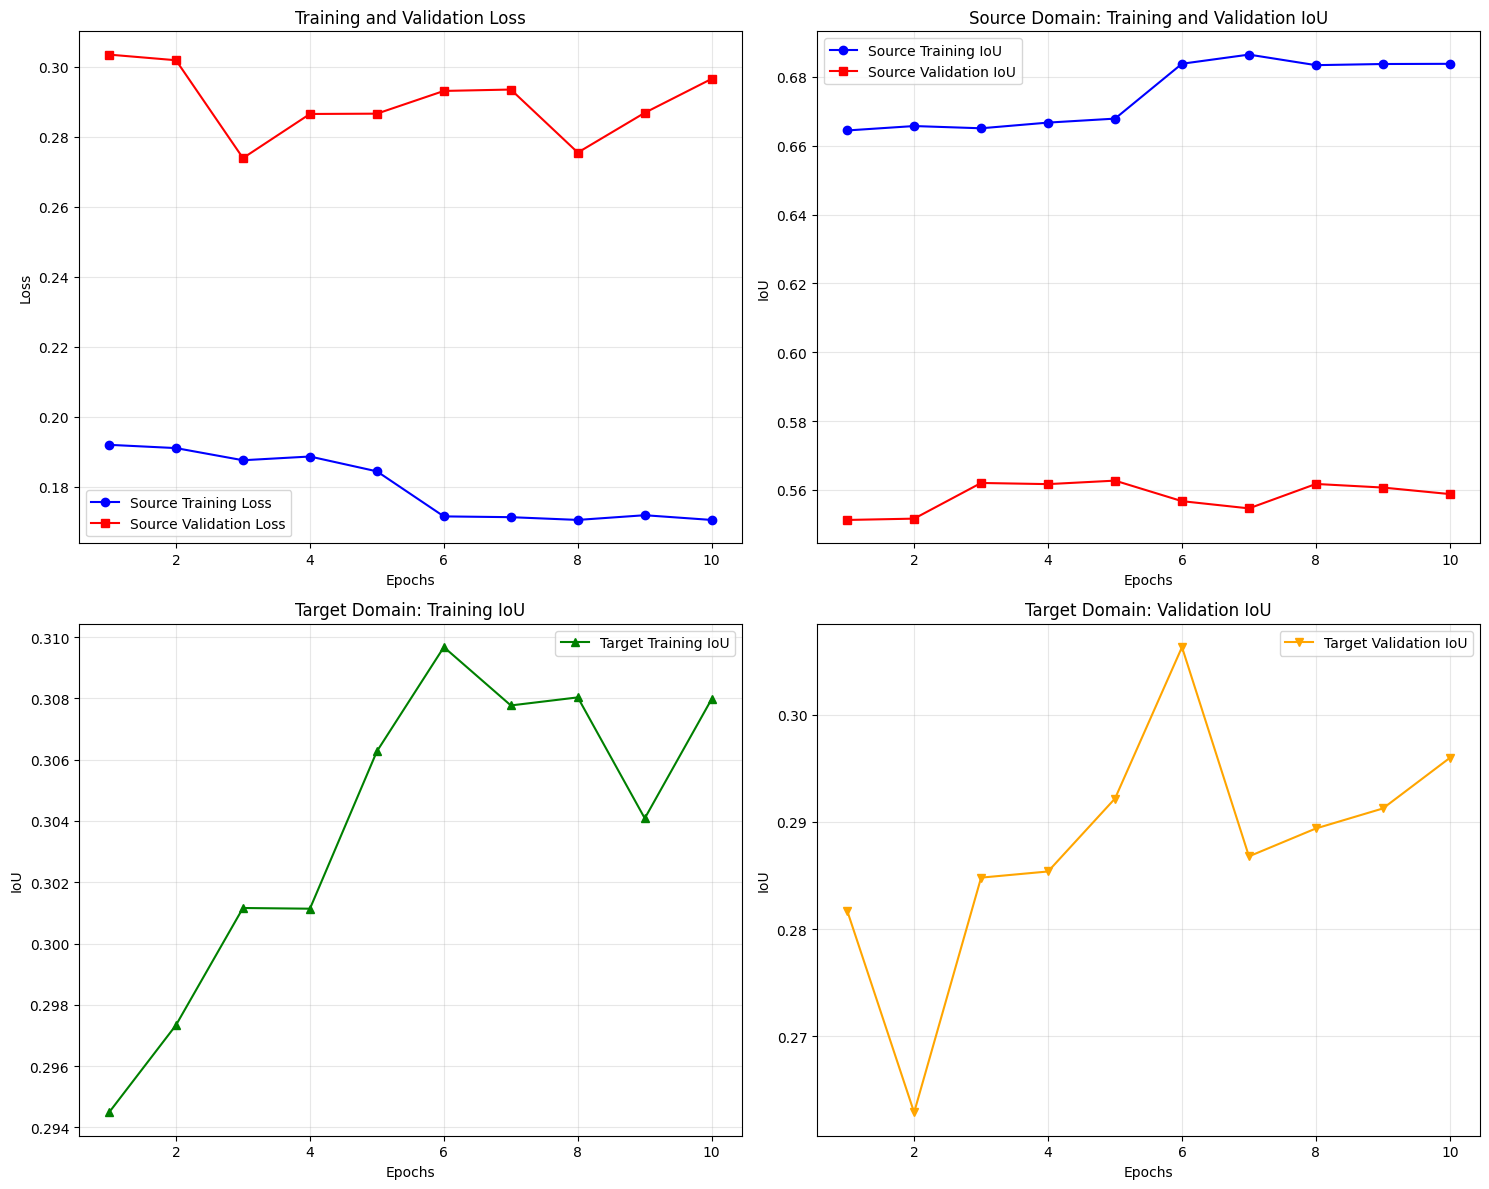

=== DOMAIN ADAPTATION TRAINING SUMMARY ===
Final Source Training Loss: 0.1704
Final Source Validation Loss: 0.2966
Final Source Training IoU: 0.6838
Final Source Validation IoU: 0.5588
Final Target Training IoU: 0.3080
Final Target Validation IoU: 0.2960

Best Source Validation IoU: 0.5627 (Epoch 5)
Best Source Training IoU: 0.6865 (Epoch 7)
Best Target Validation IoU: 0.3063 (Epoch 6)


In [34]:
name = "DA_lowerMMD_unet_imagenet1k_480x256"
plot_training_metrics_from_checkpoint(10, name=name)

## Minimum mmd parameter - 0.01

In [ ]:
mmd_weight = 0.01
#load previous best model
best_model_path = "models/unet_imagenet1k_480x256_best_model.pth" 
checkpoint = torch.load(best_model_path, map_location=DEVICE)
print (f"Loading model from: {best_model_path}")
state_dict = checkpoint["model_state_dict"]
filtered_state_dict = {k: v for k, v in state_dict.items() if not
    k.startswith("aux_classifier.")}
model.load_state_dict(filtered_state_dict, strict=False)

In [ ]:
start_epoch = 0
end_epoch = 5

# Model name for saving
name = "DA_minMMD_unet_imagenet1k_480x256"

domain_adaptation(
    start_epoch=start_epoch,  
    end_epoch=end_epoch,   
    model=model,
    name=name, 
    optimizer=optimizer, 
    criterion=criterion, 
    syn_train_dataloader=syn_train_dataloader, 
    syn_val_dataloader=syn_val_dataloader, 
    real_train_dataloader=real_train_dataloader, 
    real_val_dataloader=real_val_dataloader
)

**Domain Adaptation Training Results**

**System**: MPS (Apple Silicon) | **Seed**: 42 | **Architecture**: Unet with ImageNet1k weights | **MMD Weight**: 0.01

**Dataset Info:**
- **Synthetic**: 12,500 images (Train: 7,500 | Val: 1,250 | Test: 3,750) → Batches: 1,875 | 313 | 938
- **Real**: 5,000 images (Train: 2,975 | Val: 500 | Test: 1,525) → Batches: 744 | 125 | 382

**Starting Training**: Loading from `models/unet_imagenet1k_480x256_best_model.pth`

**Epoch 1/5**

Training: 100% - 744/744 [14:40<00:00, 1.18s/it]
Validation: 100% - 125/125 [01:09<00:00, 1.80it/s]

- **MMD Loss**: 0.4999
- **Source Train**: Loss 0.1714 | IoU 0.6659 | **Target Train IoU**: 0.2962
- **Source Val**: Loss 0.2999 | IoU 0.5529 | **Target Val IoU**: 0.2899
- New best source model saved (Source Val IoU: 0.5529)
- New best target model saved (Target Val IoU: 0.2899)

**Epoch 2/5**

Training: 100% - 744/744 [14:52<00:00, 1.20s/it]
Validation: 100% - 125/125 [01:10<00:00, 1.77it/s]

- **MMD Loss**: 0.4995
- **Source Train**: Loss 0.1707 | IoU 0.6672 | **Target Train IoU**: 0.3003
- **Source Val**: Loss 0.3018 | IoU 0.5477 | **Target Val IoU**: 0.2690

**Epoch 3/5**

Training: 100% - 744/744 [15:07<00:00, 1.22s/it]
Validation: 100% - 125/125 [01:14<00:00, 1.67it/s]

- **MMD Loss**: 0.4991
- **Source Train**: Loss 0.1679 | IoU 0.6655 | **Target Train IoU**: 0.3040
- **Source Val**: Loss 0.2720 | IoU 0.5642 | **Target Val IoU**: 0.2837
- New best source model saved (Source Val IoU: 0.5642)

**Epoch 4/5**

Training: 100% - 744/744 [15:22<00:00, 1.24s/it]
Validation: 100% - 125/125 [01:18<00:00, 1.60it/s]

- **MMD Loss**: 0.4988
- **Source Train**: Loss 0.1697 | IoU 0.6672 | **Target Train IoU**: 0.3030
- **Source Val**: Loss 0.2905 | IoU 0.5605 | **Target Val IoU**: 0.2839

**Epoch 5/5**

Training: 100% - 744/744 [15:34<00:00, 1.26s/it]
Validation: 100% - 125/125 [01:24<00:00, 1.49it/s]

- **MMD Loss**: 0.4978
- **Source Train**: Loss 0.1661 | IoU 0.6679 | **Target Train IoU**: 0.3057
- **Source Val**: Loss 0.2861 | IoU 0.5613 | **Target Val IoU**: 0.2933
- New best target model saved (Target Val IoU: 0.2933)

**Final Results:**
- Training Time: 4,920.56 seconds (1.37 hours) | Epochs: 5
- Best Source Val IoU: 0.5642 | Best Target Val IoU: 0.2933

**Saved Models:**
- Final: `models/DA_minMMD_unet_imagenet1k_480x256_epoch_5.pth`
- Best Source: `models/DA_minMMD_unet_imagenet1k_480x256_best_unsupervised_model.pth`
- Best Target: `models/DA_minMMD_unet_imagenet1k_480x256_best_supervised_model.pth`

In [ ]:
start_epoch = 5
end_epoch = 10

# Model name for saving
name = "DA_minMMD_unet_imagenet1k_480x256"

domain_adaptation(
    start_epoch=start_epoch,  
    end_epoch=end_epoch,   
    model=model,
    name=name, 
    optimizer=optimizer, 
    criterion=criterion, 
    syn_train_dataloader=syn_train_dataloader, 
    syn_val_dataloader=syn_val_dataloader, 
    real_train_dataloader=real_train_dataloader, 
    real_val_dataloader=real_val_dataloader
)

**Domain Adaptation Training Results (Continued)**

**System**: MPS (Apple Silicon) | **Seed**: 42 | **Architecture**: Unet with ImageNet1k weights | **MMD Weight**: 0.01 | **Loaded from**: `models/DA_minMMD_unet_imagenet1k_480x256_epoch_5.pth`

**Dataset Info:**
- **Synthetic**: 12,500 images (Train: 7,500 | Val: 1,250 | Test: 3,750) → Batches: 1,875 | 313 | 938
- **Real**: 5,000 images (Train: 2,975 | Val: 500 | Test: 1,525) → Batches: 744 | 125 | 382

**Resumed from Epoch 5**: Source Val IoU: 0.5613, Target Val IoU: 0.2933
**Best Loaded**: Source Val IoU: 0.5642 | Target Val IoU: 0.2933

**Epoch 6/10**

Training: 100% - 744/744 [15:50<00:00, 1.28s/it]
Validation: 100% - 125/125 [01:09<00:00, 1.80it/s]

- **MMD Loss**: 0.4964
- **Source Train**: Loss 0.1532 | IoU 0.6842 | **Target Train IoU**: 0.3103
- **Source Val**: Loss 0.2874 | IoU 0.5606 | **Target Val IoU**: 0.3035
- New best target model saved (Target Val IoU: 0.3035)

**Epoch 7/10**

Training: 100% - 744/744 [16:03<00:00, 1.29s/it]
Validation: 100% - 125/125 [01:11<00:00, 1.75it/s]

- **MMD Loss**: 0.4937
- **Source Train**: Loss 0.1541 | IoU 0.6851 | **Target Train IoU**: 0.3067
- **Source Val**: Loss 0.2904 | IoU 0.5566 | **Target Val IoU**: 0.2893

**Epoch 8/10**

Training: 100% - 744/744 [16:15<00:00, 1.31s/it]
Validation: 100% - 125/125 [01:15<00:00, 1.66it/s]

- **MMD Loss**: 0.4908
- **Source Train**: Loss 0.1514 | IoU 0.6860 | **Target Train IoU**: 0.3091
- **Source Val**: Loss 0.2704 | IoU 0.5644 | **Target Val IoU**: 0.2751
- New best source model saved (Source Val IoU: 0.5644)

**Epoch 9/10**

Training: 100% - 744/744 [16:30<00:00, 1.33s/it]
Validation: 100% - 125/125 [01:18<00:00, 1.59it/s]

- **MMD Loss**: 0.4880
- **Source Train**: Loss 0.1525 | IoU 0.6868 | **Target Train IoU**: 0.3068
- **Source Val**: Loss 0.2948 | IoU 0.5547 | **Target Val IoU**: 0.2852

**Epoch 10/10**

Training: 100% - 744/744 [16:47<00:00, 1.35s/it]
Validation: 100% - 125/125 [01:24<00:00, 1.48it/s]

- **MMD Loss**: 0.4852
- **Source Train**: Loss 0.1537 | IoU 0.6832 | **Target Train IoU**: 0.3050
- **Source Val**: Loss 0.2884 | IoU 0.5641 | **Target Val IoU**: 0.2912

**Final Results:**
- Training Time: 5,271.96 seconds (1.46 hours) | Epochs: 10
- Best Source Val IoU: 0.5644 | Best Target Val IoU: 0.3035

**Saved Models:**
- Final: `models/DA_minMMD_unet_imagenet1k_480x256_epoch_10.pth`
- Best Source: `models/DA_minMMD_unet_imagenet1k_480x256_best_unsupervised_model.pth`
- Best Target: `models/DA_minMMD_unet_imagenet1k_480x256_best_supervised_model.pth`

loaded checkpoint ../models/DA_minMMD_unet_imagenet1k_480x256_epoch_10.pth


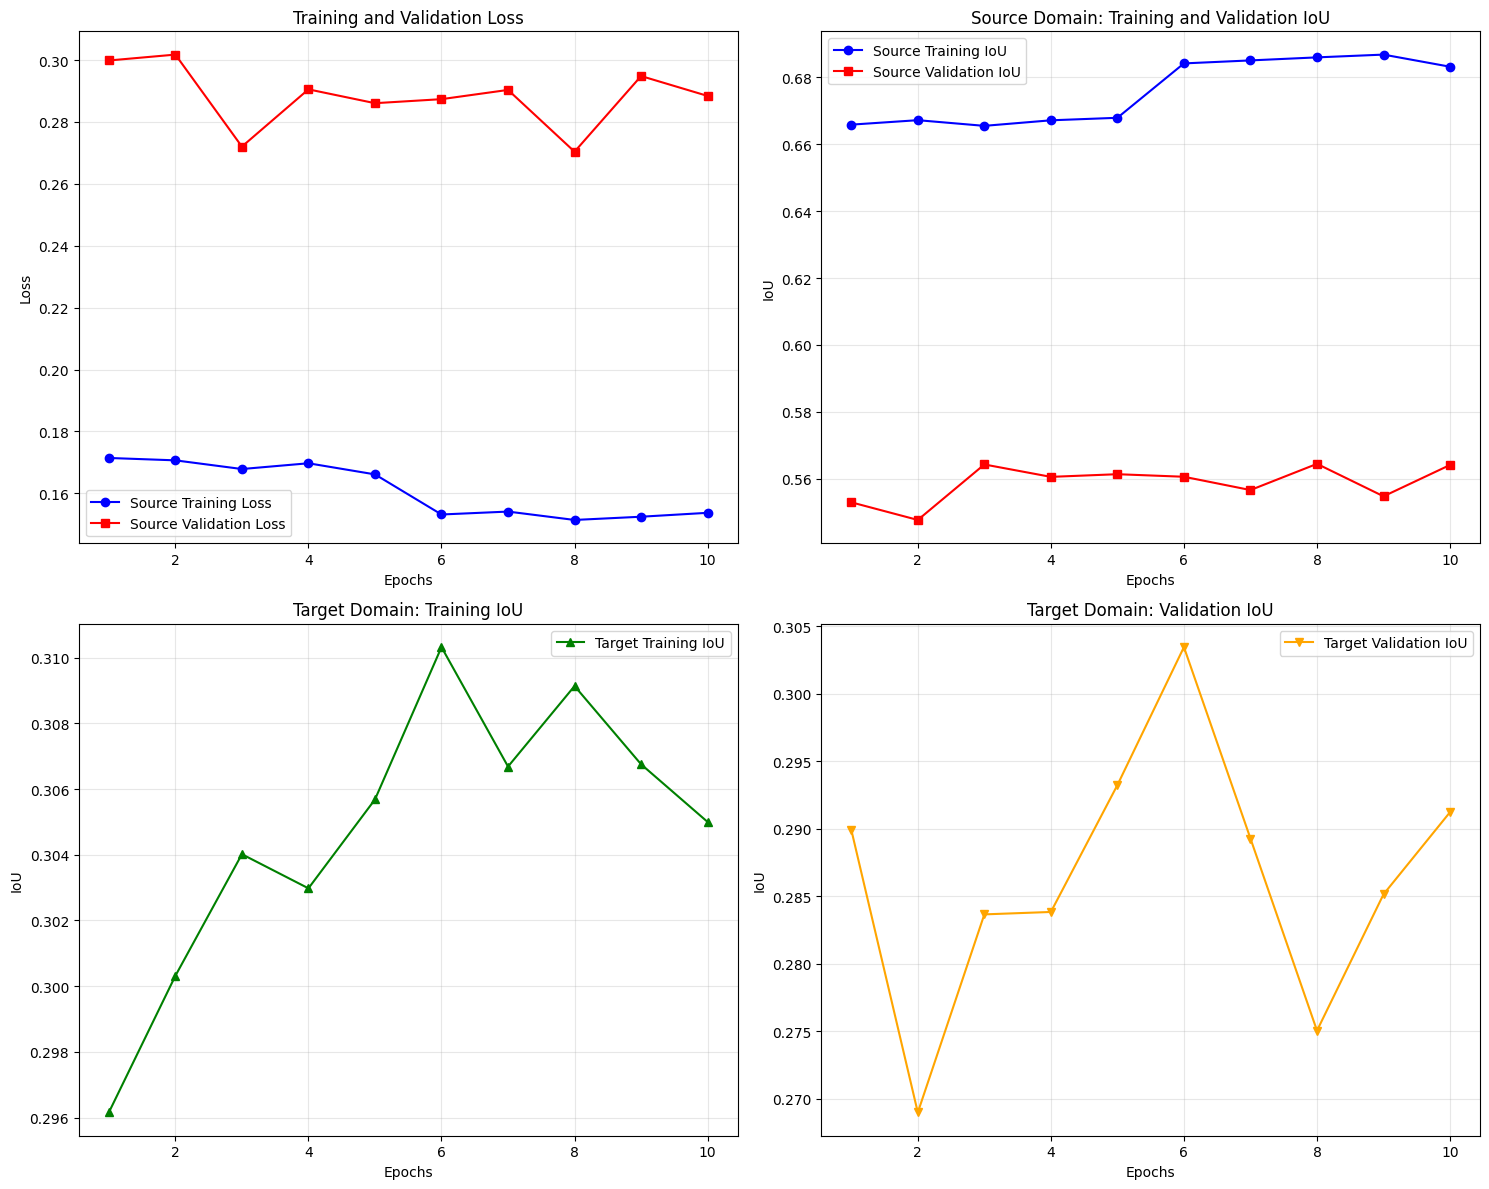

=== DOMAIN ADAPTATION TRAINING SUMMARY ===
Final Source Training Loss: 0.1537
Final Source Validation Loss: 0.2884
Final Source Training IoU: 0.6832
Final Source Validation IoU: 0.5641
Final Target Training IoU: 0.3050
Final Target Validation IoU: 0.2912

Best Source Validation IoU: 0.5644 (Epoch 8)
Best Source Training IoU: 0.6868 (Epoch 9)
Best Target Validation IoU: 0.3035 (Epoch 6)


In [35]:
name = "DA_minMMD_unet_imagenet1k_480x256"
plot_training_metrics_from_checkpoint(10, name=name)